## PINN framework for laminated plates
This framework predicts the bending behavior of laminated plates based on Classical Laminate Plate Theory (CLPT). Taking a simply supported (0/90) plate under uniform distributed load (UDL) as an example, other cases can be predicted by modifying the parameters in the code.

In [4]:
# !pip install pandas numpy torch tqdm matplotlib

## Import libraries

In [5]:
# Essential libraries
import numpy as np
import pandas as pd 
import math

import torch
import torch.nn as nn

import matplotlib.pyplot as plt 
import matplotlib.ticker as ticker
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from tqdm import trange

In [6]:
# Clear CUDA cache and check for available device (GPU or CPU)
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} (CUDA available: {torch.cuda.is_available()})")

Using device: cpu (CUDA available: False)


## Define neural network

In [7]:
# Define FNN
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=[20, 20, 5], activation='tanh'):
        
        super(NeuralNetwork, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size[0]))
        if activation == 'relu': layers.append(nn.ReLU())
        elif activation == 'sigmoid': layers.append(nn.Sigmoid())
        elif activation == 'tanh': layers.append(nn.Tanh())
        else: layers.append(nn.Softplus())    
            
        for i in range(len(hidden_size) - 1):
            layers.append(nn.Linear(hidden_size[i], hidden_size[i+1]))
            if activation == 'relu': layers.append(nn.ReLU())
            elif activation == 'sigmoid': layers.append(nn.Sigmoid())
            elif activation == 'tanh': layers.append(nn.Tanh())
            else: layers.append(nn.Softplus())
        
        layers.append(nn.Linear(hidden_size[-1], output_size))
    
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

In [8]:
# Auto differential
def auto_grad(u, x, order=1):
    if order == 1:
        return torch.autograd.grad(u, x, torch.ones_like(u), retain_graph=True, create_graph=True)[0]
    return auto_grad(auto_grad(u, x), x, order - 1)

# Xavier initialization
def xavier_init(layer):
    if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)  # Xavier initialization for weights
        nn.init.zeros_(layer.bias)  # Initialize biases to zero

## CLPT stiffness matrix

In [9]:
# Calculate the transformed matrix
def transformed_matrix(phi,opt):

    anpha=np.deg2rad(phi)
    m=math.cos(anpha)
    n=math.sin(anpha)
    if abs(m) < 2.2204e-10: m=0
    if abs(n) < 2.2204e-10: n=0    
  
    if opt==1:
        T = np.array([
            [m**2, n**2, 2*m*n ],
            [n**2, m**2, -2*m*n ],
            [-m*n, m*n, m**2-n**2]
            ])
    else:
        T = np.array([
            [m**2, n**2, m*n ],
            [n**2, m**2, -m*n ],
            [-2*m*n, 2*m*n, m**2-n**2]
            ])
    return T

In [10]:
# Define geometric parameters
a = 5 
b = 5 
h = 1 # Total thickness of the laminate
n_layer = 2 # Number of layers
t = h/n_layer # Thickness of each layer
phi = [0,90] # lay-ups
q0 = 1e-3 
# SDL: q0 * torch.sin(3.1415/2*(x[:,0]+1)).view(-1,1)* torch.sin(3.1415/2*(x[:,1]+1)).view(-1,1)

# Define material parameters
E1 = 25
E2 = E1/25
G12 = 0.5*E2
mu12 = 0.25
mu21 = mu12*E2/E1

# Stiffness matrix for an orthotropic material
Q11 = E1/(1 - mu12*mu21)
Q12 = mu12*E2/(1 - mu12*mu21)
Q22 = E2/(1 - mu12*mu21)
Q66 = G12    
Q = np.array([[Q11, Q12 , 0],[Q12 , Q22, 0],[0, 0, Q66]])

# Transform stiffness matrix for each layer
Q_bar =[]
for i in range(n_layer):
        T2=transformed_matrix(phi[i],2)
        Q2=T2.T@Q@T2
        Q_bar.append(Q2)
        
# Calculate z-coordinates for each layer       
z1 = []
for i in range(n_layer):
    zi=((i)-n_layer/2)*t
    z1.append(zi)
z1 = np.array(z1)

z2 = []
for i in range(n_layer):
    zi=((i+1)-n_layer/2)*t
    z2.append(zi)
z2 = np.array(z2)

# Compute A, B, D matrices
A = np.zeros(shape=(3,3))
B = np.zeros(shape=(3,3))
D = np.zeros(shape=(3,3))
for i in range(n_layer):
    A = A + Q_bar[i] * (z2[i] - z1[i])
    B = B + Q_bar[i] * (z2[i]**2 - z1[i]**2)/2
    D = D + Q_bar[i] * (z2[i]**3 - z1[i]**3)/3
    
print("A matrix:\n", A)
print("B matrix:\n", B)
print("D matrix:\n", D)

A matrix:
 [[13.03258145  0.25062657  0.        ]
 [ 0.25062657 13.03258145  0.        ]
 [ 0.          0.          0.5       ]]
B matrix:
 [[-3.0075188  0.         0.       ]
 [ 0.         3.0075188  0.       ]
 [ 0.         0.         0.       ]]
D matrix:
 [[1.08604845 0.02088555 0.        ]
 [0.02088555 1.08604845 0.        ]
 [0.         0.         0.04166667]]


## Training data

In [11]:
# Define sampling point
def train_data(Nx, Ny, Nf):
    
    xu = np.linspace(-1, 1, Nx).reshape([Nx, 1])
    yu = np.linspace(-1, 1, Ny).reshape([Ny, 1]) 
    X, Y = np.meshgrid(xu, yu)
    Xf1 = np.vstack([X.ravel(), Y.ravel()]).T
    Xf1 = torch.tensor(Xf1, dtype=torch.float32, requires_grad=True)

    Xf2 = np.random.rand(Nf,2)*2-1
    Xf2 = torch.tensor(Xf2, dtype=torch.float32, requires_grad=True)
    
    return Xf1, Xf2

In [12]:
# Prepare training data
Nxb = 100
Nyb = 100
Nf1 = 10000

Xf1, Xf2 = train_data(Nxb, Nyb, Nf1)

## Loss function

In [13]:
def Energy_loss(x, Net_w, func_w, Net_u, func_u, Net_v, func_v):
    
    q = q0
    # SDL: q = q0 * torch.sin(3.1415/2*(x[:,0]+1)).view(-1,1)* torch.sin(3.1415/2*(x[:,1]+1)).view(-1,1)    
    u = Net_u(x)*(func_u(x).view(-1,1))
    du_x = auto_grad(u, x, 1)[:,0].view(-1,1)
    du_y = auto_grad(u, x, 1)[:,1].view(-1,1)
    v = Net_v(x)*(func_v(x).view(-1,1))
    dv_x = auto_grad(v, x, 1)[:,0].view(-1,1)
    dv_y = auto_grad(v, x, 1)[:,1].view(-1,1)
    w = Net_w(x)*(func_w(x).view(-1,1))
    dw_x = auto_grad(w, x, 1)[:,0].view(-1,1)
    dw_y = auto_grad(w, x, 1)[:,1].view(-1,1)
    dw_xx = auto_grad(dw_x, x, 1)[:,0].view(-1,1)
    dw_yy = auto_grad(dw_y, x, 1)[:,1].view(-1,1)
    dw_xy = auto_grad(dw_x, x, 1)[:,1].view(-1,1)
    
    w = w*h
    dw_x, dw_y, du_y, dv_x = dw_x*h/a, dw_y*h/b, du_y*a/b, dv_x*b/a
    dw_xx, dw_yy, dw_xy = dw_xx*h/a**2, dw_yy*h/b**2, dw_xy*h/a/b
    
    eps_xx = du_x + 0.5*dw_x**2
    eps_yy = dv_y + 0.5*dw_y**2
    eps_xy = 0.5*(du_y + dv_x) + 0.5*dw_y*dw_x   
        
    k_xx = -dw_xx
    k_yy = -dw_yy
    k_xy = -dw_xy
    
    N_xx = A[0,0]*eps_xx + A[0,1]*eps_yy + A[0,2]*2*eps_xy  + B[0,0]*k_xx + B[0,1]*k_yy + B[0,2]*2*k_xy 
    N_yy = A[1,0]*eps_xx + A[1,1]*eps_yy + A[1,2]*2*eps_xy  + B[1,0]*k_xx + B[1,1]*k_yy + B[1,2]*2*k_xy 
    N_xy = A[2,0]*eps_xx + A[2,1]*eps_yy + A[2,2]*2*eps_xy  + B[2,0]*k_xx + B[2,1]*k_yy + B[2,2]*2*k_xy 
   
    M_xx = B[0,0]*eps_xx + B[0,1]*eps_yy + B[0,2]*2*eps_xy  + D[0,0]*k_xx + D[0,1]*k_yy + D[0,2]*2*k_xy
    M_yy = B[1,0]*eps_xx + B[1,1]*eps_yy + B[1,2]*2*eps_xy  + D[1,0]*k_xx + D[1,1]*k_yy + D[1,2]*2*k_xy
    M_xy = B[2,0]*eps_xx + B[2,1]*eps_yy + B[2,2]*2*eps_xy  + D[2,0]*k_xx + D[2,1]*k_yy + D[2,2]*2*k_xy
    
    U_m = 0.5*(eps_xx*N_xx + eps_yy*N_yy + 2*eps_xy*N_xy)
    U_b = 0.5*(k_xx*M_xx + k_yy*M_yy + 2*k_xy*M_xy)
    U_e = q*w 
    
    return torch.mean(U_m), torch.mean(U_b), torch.mean(U_e)

## Training Model

In [14]:
# Independent nn for three directions
Net_w = NeuralNetwork(input_size=2, output_size=1, hidden_size=[5, 5, 5, 5, 5], activation='tanh').to(device)
Net_u = NeuralNetwork(input_size=2, output_size=1, hidden_size=[5, 5, 5, 5, 5], activation='tanh').to(device)
Net_v = NeuralNetwork(input_size=2, output_size=1, hidden_size=[5, 5, 5, 5, 5], activation='tanh').to(device)
Net_w.apply(xavier_init)
Net_u.apply(xavier_init)
Net_v.apply(xavier_init)

# Hard constrains for essential BCs (SSSS)
func_w = lambda x: ((x[:,0]+1)*(x[:,0]-1)*(x[:,1]+1)*(x[:,1]-1))
func_u = lambda x: (x[:,1]+1)*(x[:,1]-1)
func_v = lambda x: (x[:,0]+1)*(x[:,0]-1)

In [15]:
# Choose optimizer
params = list(Net_w.parameters()) + list(Net_u.parameters()) + list(Net_v.parameters())
optimizer_Adam = torch.optim.Adam(params, lr=0.001)
optimizer_LBFGS = torch.optim.LBFGS(params, lr=0.001, 
                                    max_iter=50000, max_eval=50000, history_size=50,
                                    tolerance_grad=1e-5, tolerance_change=1.0 * np.finfo(float).eps, 
                                    line_search_fn="strong_wolfe"
                                    )
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_Adam, step_size=1000, gamma=0.9)

In [16]:
# Train the model
epochs = 10_000
initial_epochs = 100

td = trange(epochs, dynamic_ncols=True, ncols=50)
training_loss_hist = []
W_pred_hist = []
Net_u.train().to(device)
Net_v.train().to(device)
Net_w.train().to(device)

for epoch in td:
    if epoch < initial_epochs:
        Xf1, _ = train_data(Nxb, Nyb, Nf1)
        Xf = Xf1.to(device)
    else:
        _, Xf2 = train_data(Nxb, Nyb, Nf1)
        Xf = Xf2.to(device)
        
    U_m, U_b, U_e = Energy_loss(Xf, Net_w, func_w, Net_u, func_u, Net_v, func_v)
    loss = U_m + U_b - U_e
    loss.backward()
    optimizer_Adam.step()
    optimizer_Adam.zero_grad()
    training_loss_hist.append(loss.item())  
    #scheduler.step()
    if (epoch+1) % 1 ==0: 
        with torch.no_grad():
            W_pred = Net_w( Xf1.to(device)) * func_w(Xf1.to(device)).view(-1,1) * 100 * (h)**3 * E2 / q0 / (2*a)**4
            W_pred = W_pred.cpu()
            W_pred_hist.append(max(W_pred))

    td.set_description(
        f" Total:{loss:.2e}, Um:{U_m:.2e}, Ub:{U_b:.2e}, Ue:{U_e:.4e}, Wmax:{max(W_pred).item():.4f}"
    )
    

 Total:-3.45e-05, Um:-4.39e-07, Ub:3.51e-05, Ue:6.9090e-05, Wmax:1.6814: 100%|██████████| 10000/10000 [53:33<00:00,  3.11it/s] 


## Deformation predictions

In [19]:
Net_w.eval().cpu()
Net_u.eval().cpu()
Net_v.eval().cpu()
W = Net_w(Xf1)*(func_w(Xf1).view(-1,1))
W_pred = W.detach().numpy().reshape(-1,1)*h
W_bar = W_pred*100*(h)**3*E2/q0/(2*a)**4
X = Xf1[:,0].detach().numpy().reshape(-1,1)*a
Y = Xf1[:,1].detach().numpy().reshape(-1,1)*b

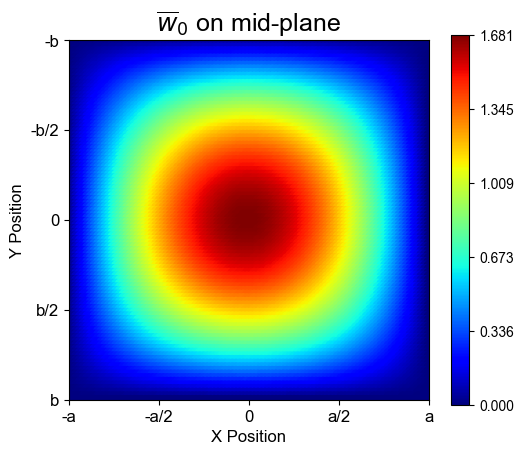

In [29]:
plt.rcParams['font.family'] = 'Arial'

fig, ax = plt.subplots(figsize=(5.8, 4.8)) 

surf = ax.scatter(X, Y, c=W_bar, cmap=cm.jet)

cb = fig.colorbar(surf, ax=ax, orientation='vertical')
cb.ax.tick_params(labelsize=10)

vmin = W_bar.min().item()
vmax = W_bar.max().item()
num_ticks = 6
ticks = np.linspace(vmin, vmax, num_ticks)
cb.set_ticks(ticks)

# ax.axis('equal')
# ax.set_xlabel('X Position (mm)', fontsize=6)
# ax.set_ylabel('Y Position (mm)', fontsize=6)

ax.tick_params(axis='both', which='major', labelsize=16)

ax.set_title(r'$\overline{w}_{0}$ on mid-plane', fontsize=18)

ax.set_xlim([X.min(), X.max()])
ax.set_ylim([Y.max(), Y.min()])

xticks = [-5, -2.5, 0, 2.5, 5] 
xlabels = ['-a', '-a/2', '0', 'a/2', 'a']
yticks = [-5, -2.5, 0, 2.5, 5]
ylabels = ['-b', '-b/2', '0', 'b/2', 'b'] 
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels, fontsize=12)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels, fontsize=12)

ax.set_xlabel('X Position', fontsize=12)
ax.set_ylabel('Y Position', fontsize=12)

ax.set_aspect('equal', adjustable='box')

plt.show()

## Stress comparison with FEM

In [32]:
FEM_data = pd.read_csv('data/FEM.csv')
FEM_data.head(7)

,X,Y,Z,S-S11,S-S22,S-S12,U-U3
0,500.0,500.0,0.0,-0.000185,-0.00248,-0.0909,0.000000e+00
1,490.0,500.0,0.0,0.000054,0.00102,-0.0916,1.110000e-38
2,480.0,500.0,0.0,0.000372,0.00335,-0.0916,2.250000e-38
3,470.0,500.0,0.0,0.000468,0.00421,-0.0910,1.550000e-38
4,460.0,500.0,0.0,0.000578,0.00582,-0.0904,1.920000e-38
5,450.0,500.0,0.0,0.000687,0.00667,-0.0896,1.680000e-38
6,440.0,500.0,0.0,0.000771,0.00789,-0.0888,1.780000e-38


In [33]:
coord = FEM_data.iloc[:,0:2].to_numpy()
coord_nor = coord/500
X = coord_nor[:, 0]
Y = coord_nor[:, 1]
sigma = FEM_data.iloc[:,3:6].to_numpy()
sigmaxx = sigma[:, 0].reshape(-1, 1)
sigmayy = sigma[:, 1].reshape(-1, 1)
sigmaxy = sigma[:, 2].reshape(-1, 1)

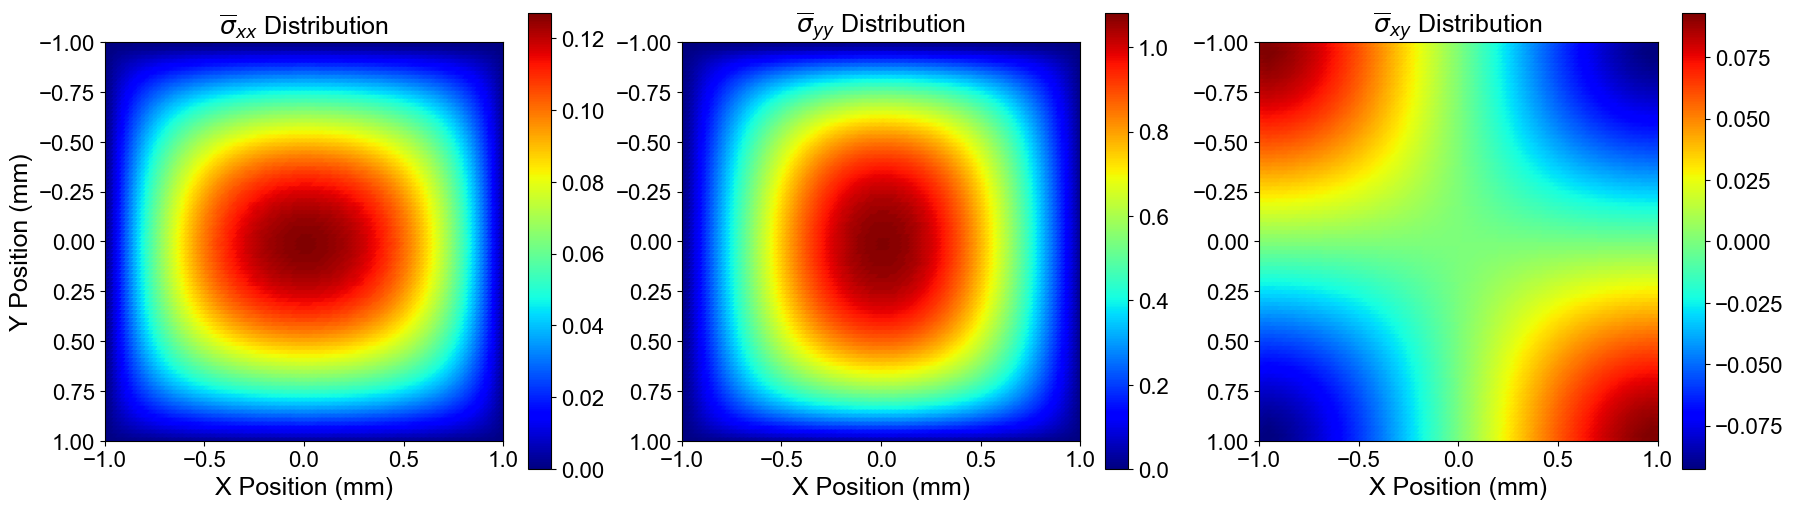

In [35]:
plt.rcParams['font.family'] = 'Arial'

fig, axes = plt.subplots(1, 3, figsize=(18, 6)) 
xticks = [-1, -0.5, 0, 0.5, 1] 
xlabels = ['-a', '-a/2', '0', 'a/2', 'a']
yticks = [-1, -0.5, 0, 0.5, 1]
ylabels = ['-b', '-b/2', '0', 'b/2', 'b'] 
surf1 = axes[0].scatter(X, Y, c=sigmaxx, cmap=cm.jet)
cb1 = fig.colorbar(surf1, ax=axes[0], orientation='vertical', shrink=0.8)
cb1.ax.tick_params(labelsize=16)
axes[0].axis('equal')
axes[0].set_xlabel('X Position (mm)', fontsize=18)
axes[0].set_ylabel('Y Position (mm)', fontsize=18)
axes[0].set_title(r'$\overline{\sigma}_{xx}$ Distribution', fontsize=18)
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[0].set_xlim([X.min(), X.max()])
axes[0].set_ylim([Y.max(), Y.min()])
axes[0].set_aspect('equal', adjustable='box')

surf2 = axes[1].scatter(X, Y, c=sigmayy, vmin=0, cmap=cm.jet)
cb2 = fig.colorbar(surf2, ax=axes[1], orientation='vertical', shrink=0.8)
cb2.ax.tick_params(labelsize=16)
axes[1].axis('equal')
axes[1].set_xlabel('X Position (mm)', fontsize=18)
axes[1].set_title(r'$\overline{\sigma}_{yy}$ Distribution', fontsize=18)
axes[1].tick_params(axis='both', which='major', labelsize=16)
axes[1].set_xlim([X.min(), X.max()])
axes[1].set_ylim([Y.max(), Y.min()])
axes[1].set_aspect('equal', adjustable='box')

surf3 = axes[2].scatter(X, Y, c=-sigmaxy, cmap=cm.jet)
cb3 = fig.colorbar(surf3, ax=axes[2], orientation='vertical', shrink=0.8)
cb3.ax.tick_params(labelsize=16)
axes[2].axis('equal')
axes[2].set_xlabel('X Position (mm)', fontsize=18)
axes[2].set_title(r'$\overline{\sigma}_{xy}$ Distribution', fontsize=18)
axes[2].tick_params(axis='both', which='major', labelsize=16)
axes[2].set_xlim([X.min(), X.max()])
axes[2].set_ylim([Y.max(), Y.min()])
axes[2].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

In [36]:
X_inp = torch.tensor(coord_nor, dtype=torch.float32, requires_grad=True)
u = Net_u(X_inp)*(func_u(X_inp).view(-1,1))
du_x = auto_grad(u, X_inp, 1)[:,0].view(-1,1)
du_y = auto_grad(u, X_inp, 1)[:,1].view(-1,1)
v = Net_v(X_inp)*(func_v(X_inp).view(-1,1))
dv_x = auto_grad(v, X_inp, 1)[:,0].view(-1,1)
dv_y = auto_grad(v, X_inp, 1)[:,1].view(-1,1)
w = Net_w(X_inp)*(func_w(X_inp).view(-1,1))
dw_x = auto_grad(w, X_inp, 1)[:,0].view(-1,1)
dw_y = auto_grad(w, X_inp, 1)[:,1].view(-1,1)
dw_xx = auto_grad(dw_x, X_inp, 1)[:,0].view(-1,1)
dw_yy = auto_grad(dw_y, X_inp, 1)[:,1].view(-1,1)
dw_xy = auto_grad(dw_x, X_inp, 1)[:,1].view(-1,1)

w = w*h
dw_x, dw_y, du_y, dv_x = dw_x*h/a, dw_y*h/b, du_y*a/b, dv_x*b/a
dw_xx, dw_yy, dw_xy = dw_xx*h/a**2, dw_yy*h/b**2, dw_xy*h/a/b

eps_xx = du_x + 0.5*dw_x**2
eps_yy = dv_y + 0.5*dw_y**2
eps_xy = 0.5*(du_y + dv_x) + 0.5*dw_y*dw_x   

k_xx = -dw_xx
k_yy = -dw_yy
k_xy = -dw_xy

N_xx = A[0,0]*eps_xx + A[0,1]*eps_yy + A[0,2]*2*eps_xy  + B[0,0]*k_xx + B[0,1]*k_yy + B[0,2]*2*k_xy 
N_yy = A[1,0]*eps_xx + A[1,1]*eps_yy + A[1,2]*2*eps_xy  + B[1,0]*k_xx + B[1,1]*k_yy + B[1,2]*2*k_xy 
N_xy = A[2,0]*eps_xx + A[2,1]*eps_yy + A[2,2]*2*eps_xy  + B[2,0]*k_xx + B[2,1]*k_yy + B[2,2]*2*k_xy 

M_xx = B[0,0]*eps_xx + B[0,1]*eps_yy + B[0,2]*2*eps_xy  + D[0,0]*k_xx + D[0,1]*k_yy + D[0,2]*2*k_xy
M_yy = B[1,0]*eps_xx + B[1,1]*eps_yy + B[1,2]*2*eps_xy  + D[1,0]*k_xx + D[1,1]*k_yy + D[1,2]*2*k_xy
M_xy = B[2,0]*eps_xx + B[2,1]*eps_yy + B[2,2]*2*eps_xy  + D[2,0]*k_xx + D[2,1]*k_yy + D[2,2]*2*k_xy

In [37]:
PINN_sigmaxx = Q_bar[1][0,0]*eps_xx + Q_bar[1][0,1]*eps_yy + Q_bar[1][0,2]*2*eps_xy + 0.5* ( Q_bar[1][0,0]*k_xx +  Q_bar[1][0,1]*k_yy +  Q_bar[1][0,2]*2*k_xy )
PINN_sigmayy = Q_bar[1][1,0]*eps_xx + Q_bar[1][1,1]*eps_yy + Q_bar[1][1,2]*2*eps_xy + 0.5* ( Q_bar[1][1,0]*k_xx +  Q_bar[1][1,1]*k_yy +  Q_bar[1][1,2]*2*k_xy )
PINN_sigmaxy = Q_bar[1][2,0]*eps_xx + Q_bar[1][2,1]*eps_yy + Q_bar[1][2,2]*2*eps_xy + 0.5* ( Q_bar[1][2,0]*k_xx +  Q_bar[1][2,1]*k_yy +  Q_bar[1][2,2]*2*k_xy )

In [38]:
PINN_sigmaxx = PINN_sigmaxx.detach().numpy()*(h)**2/q0/(2*a)**2
PINN_sigmayy = PINN_sigmayy.detach().numpy()*(h)**2/q0/(2*a)**2
PINN_sigmaxy = PINN_sigmaxy.detach().numpy()*(h)**2/q0/(2*a)**2

In [39]:
numerator = np.sum((PINN_sigmaxx - sigmaxx)**2)  
denominator = np.sum((sigmaxx - np.mean(sigmaxx))**2) 
sigmaxx_r2 = 1 - (numerator / denominator)
print("R-squared (sigmaxx):", sigmaxx_r2)

R-squared (sigmaxx): 0.9886372186833093


In [40]:
numerator = np.sum((PINN_sigmayy - sigmayy)**2)  
denominator = np.sum((sigmayy - np.mean(sigmayy))**2) 
sigmayy_r2 = 1 - (numerator / denominator)
print("R-squared (sigmayy):", sigmayy_r2)

R-squared (sigmayy): 0.9868559846304743


In [41]:
numerator = np.sum((PINN_sigmaxy - sigmaxy)**2)  
denominator = np.sum((sigmaxy - np.mean(sigmaxy))**2) 
sigmaxy_r2 = 1 - (numerator / denominator)
print("R-squared (sigmaxy):", sigmaxy_r2)

R-squared (sigmaxy): 0.9901929826538242


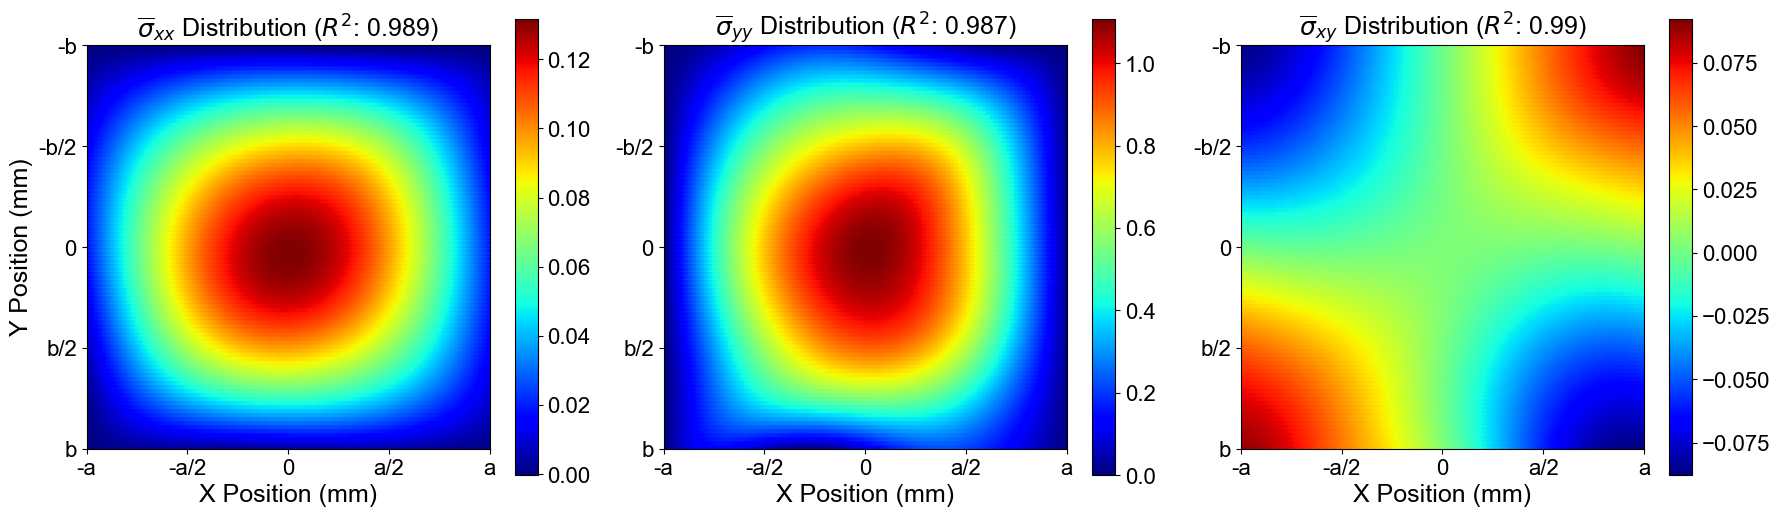

In [48]:
plt.rcParams['font.family'] = 'Arial'

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

xticks = [-1, -0.5, 0, 0.5, 1] 
xlabels = ['-a', '-a/2', '0', 'a/2', 'a']
yticks = [-1, -0.5, 0, 0.5, 1]
ylabels = ['-b', '-b/2', '0', 'b/2', 'b'] 

surf1 = axes[0].scatter(X, Y, c=PINN_sigmaxx, cmap=cm.jet)
cb1 = fig.colorbar(surf1, ax=axes[0], orientation='vertical', shrink=0.8)
cb1.ax.tick_params(labelsize=16)

axes[0].axis('equal')
axes[0].set_xlabel('X Position (mm)', fontsize=18)
axes[0].set_ylabel('Y Position (mm)', fontsize=18)
axes[0].set_title(f'$\\overline{{\\sigma}}_{{xx}}$ Distribution ($R^2$: {sigmaxx_r2.round(3)})', fontsize=18 )
axes[0].tick_params(axis='both', which='major', labelsize=16)
axes[0].set_xlim([X.min(), X.max()])
axes[0].set_ylim([Y.max(), Y.min()])
axes[0].set_xticks(xticks)
axes[0].set_xticklabels(xlabels, fontsize=16)
axes[0].set_yticks(yticks)
axes[0].set_yticklabels(ylabels, fontsize=16)
axes[0].set_aspect('equal', adjustable='box')

surf2 = axes[1].scatter(X, Y, c=PINN_sigmayy, vmin=0, cmap=cm.jet)
cb2 = fig.colorbar(surf2, ax=axes[1], orientation='vertical', shrink=0.8)
cb2.ax.tick_params(labelsize=16)

axes[1].axis('equal')
axes[1].set_xlabel('X Position (mm)', fontsize=18)
axes[1].set_title(f'$\\overline{{\\sigma}}_{{yy}}$ Distribution ($R^2$: {sigmayy_r2.round(3)})', fontsize=18 )
axes[1].tick_params(axis='both', which='major', labelsize=16)
axes[1].set_xlim([X.min(), X.max()])
axes[1].set_ylim([Y.max(), Y.min()])
axes[1].set_xticks(xticks)
axes[1].set_xticklabels(xlabels, fontsize=16)
axes[1].set_yticks(yticks)
axes[1].set_yticklabels(ylabels, fontsize=16)
axes[1].set_aspect('equal', adjustable='box')

surf3 = axes[2].scatter(X, Y, c=PINN_sigmaxy, cmap=cm.jet)
cb3 = fig.colorbar(surf3, ax=axes[2], orientation='vertical', shrink=0.8)
cb3.ax.tick_params(labelsize=16)

axes[2].axis('equal')
axes[2].set_xlabel('X Position (mm)', fontsize=18)
axes[2].set_title(f'$\\overline{{\\sigma}}_{{xy}}$ Distribution ($R^2$: {sigmaxy_r2.round(3)})', fontsize=18 )
axes[2].tick_params(axis='both', which='major', labelsize=16)
axes[2].set_xlim([X.min(), X.max()])
axes[2].set_ylim([Y.max(), Y.min()])
axes[2].set_xticks(xticks)
axes[2].set_xticklabels(xlabels, fontsize=16)
axes[2].set_yticks(yticks)
axes[2].set_yticklabels(ylabels, fontsize=16)
axes[2].set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

### Referencias.

- https://github.com/VissyWANG/laminate-bending-PINN
- https://www.sciencedirect.com/science/article/pii/S0263823125001089?ref=pdf_download&fr=RR-2&rr=914e94fae9ae56a7